## Simple Linear Regression

## Importing Libraries

In [1]:
import sys
import os

current_dir = os.getcwd() 
code_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

if code_dir not in sys.path:
    sys.path.append(code_dir)

from src.models.linear_models import LinearRegression
from src.loss_functions.regression_losses import MeanSquaredError, MeanAbsoluteError
from src.optimisers.gradient_based import BatchGradientDescent, StochasticGradientDescent, MiniBatchGradientDescent
from src.optimisers.cellular_automata import CellularAutomataOptimiser
from src.utils import configurations

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Loading the dataset

In [2]:
df = pd.read_csv("../datasets/simple_linear_regression_data.csv")
X = df.drop("target", axis=1)
y = df["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configurations.TEST_SIZE, random_state=configurations.SEED)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

n_features = 1

In [4]:
RUNS = 10

loss_functions = {
    'Mean Squared Error': MeanSquaredError(),
    'Mean Absolute Error': MeanAbsoluteError()
}
optimisers = {
    'Batch Gradient Descent': BatchGradientDescent(configurations.ALPHA),
    'Stochastic Gradient Descent': StochasticGradientDescent(configurations.ALPHA),
    'Mini Batch Gradient Descent': MiniBatchGradientDescent(configurations.ALPHA),
    'Cellular Automata Optimiser': CellularAutomataOptimiser(L=5, mu=0.01, omega=0.8)
}

In [5]:
final_aggregated_results = []
PLOTTING_CURVES_MSE = {}
PLOTTING_CURVES_MAE = {}
MAX_ITERS = 1000

In [6]:
print('==================== CONFIGURATIONS ====================')
print(f"MAX_ITERS={configurations.MAX_ITERS}, TEST_SIZE={configurations.TEST_SIZE}, ALPHA={configurations.ALPHA}")
print('='*56)

==================== CONFIGURATIONS ====================
MAX_ITERS=1000, TEST_SIZE=0.2, ALPHA=0.001


In [7]:
# use one optimiser at a time
for optimiser_name, optimiser in optimisers.items():
    # use one loss function at a time
    for loss_name, loss_func in loss_functions.items():
        print('='*75)
        print(f'Running Combination: {optimiser_name} / {loss_name}')

        # metric used for evaluation
        losses_for_avg = []
        r2_score_for_avg = []
        run_times_for_avg = []
        loss_per_iterations = []

        # test every optimiser for 10 runs
        for i in range(RUNS):
            model = LinearRegression(n_features=n_features)
            model.set_param_bounds([(-1000.0, 1000.0)])

            # calculating the time for each run
            start_time = time.time()
            optimiser_results = optimiser.optimise(model, loss_func, X_train, y_train, max_iters=MAX_ITERS) 
            run_time = time.time() - start_time

            model.set_params(optimiser_results['parameters'])
            y_pred = model.predict(X_test)
            
            losses_for_avg.append(optimiser_results['best_loss'])
            r2_score_for_avg.append(r2_score(y_test, y_pred))
            run_times_for_avg.append(run_time)
            loss_per_iterations.append(optimiser_results['loss_history']) # this will store all the losses per iteration from 1 to 1000

        losses_array = np.array(losses_for_avg)
        r2_score_array = np.array(r2_score_for_avg)
        run_times_array = np.array(run_times_for_avg)
        loss_per_iterations_array = np.array(loss_per_iterations)

        avg_loss = np.mean(losses_array)
        std_dev_loss = np.std(losses_array)
        avg_r2_score = np.mean(r2_score_array)
        std_dev_r2_score = np.std(r2_score_array)
        avg_time = np.mean(run_times_array)
        std_dev_time = np.std(run_times_array)
        avg_loss_per_iter = np.mean(loss_per_iterations_array, axis=0)

        if loss_name == 'Mean Squared Error':
            PLOTTING_CURVES_MSE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MSE curve for {optimiser_name}.")
        elif loss_name == 'Mean Absolute Error':
            PLOTTING_CURVES_MAE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MAE curve for {optimiser_name}.")

        final_aggregated_results.append({
        'Optimiser': optimiser_name,
        'Loss_Function': loss_name,
        'Avg_Loss': avg_loss,
        'Std_Dev_Loss': std_dev_loss,
        'Avg_R2_Score': avg_r2_score,
        'Std_Dev_R2_Score': std_dev_r2_score,
        'Avg_Time_s': avg_time,
        'Std_Dev_Time_s': std_dev_time
        })

Running Combination: Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Batch Gradient Descent.
Running Combination: Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Batch Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Stochastic Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Stochastic Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Mini Batch Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Mini Batch Gradient Descent.
Running Combination: Cellular Automata Optimiser / Mean Squared Error
-> Stored average MSE curve for Cellular Automata Optimiser.
Running Combination: Cellular Automata Optimiser / Mean Absolute Error
-> Stored average MAE curve f

In [8]:
results_df = pd.DataFrame(final_aggregated_results)
results_df

,Optimiser,Loss_Function,Avg_Loss,Std_Dev_Loss,Avg_R2_Score,Std_Dev_R2_Score,Avg_Time_s,Std_Dev_Time_s
0,Batch Gradient Descent,Mean Squared Error,17062.654313,1.304913e+04,-9.487307,8.722638e+00,0.011002,0.000533
1,Batch Gradient Descent,Mean Absolute Error,538.291049,2.301505e+02,-259.550675,1.811828e+02,0.011444,0.001143
2,Stochastic Gradient Descent,Mean Squared Error,73.137437,3.178306e-03,0.937423,7.125203e-05,0.839477,0.005090
3,Stochastic Gradient Descent,Mean Absolute Error,521.619164,2.508444e+02,-260.678000,2.118301e+02,0.877323,0.006350
4,Mini Batch Gradient Descent,Mean Squared Error,88.749896,1.596389e+01,0.932333,1.142376e-02,0.037022,0.000823
5,Mini Batch Gradient Descent,Mean Absolute Error,482.991380,2.314102e+02,-225.632538,1.794468e+02,0.038287,0.000981
6,Cellular Automata Optimiser,Mean Squared Error,72.922528,7.315485e-14,0.937415,7.002033e-10,2.750252,0.029235
7,Cellular Automata Optimiser,Mean Absolute Error,6.834430,4.116322e-05,0.935296,1.441290e-05,1.920580,0.209542


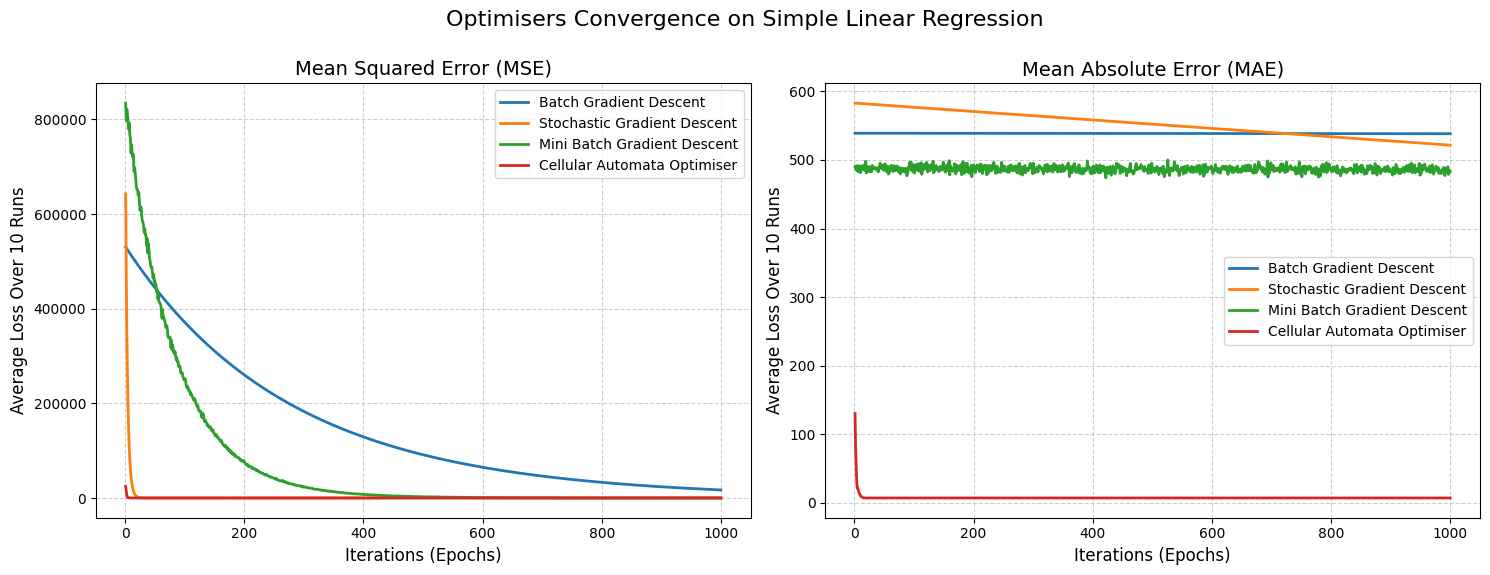

In [9]:
iterations = np.arange(1, MAX_ITERS + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# for Mean Squared Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MSE.items():
    ax[0].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[0].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# for Mean Absolute Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MAE.items():
    ax[1].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[1].set_title('Mean Absolute Error (MAE)', fontsize=14)
ax[1].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[1].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

fig.suptitle('Optimisers Convergence on Simple Linear Regression', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Simple Linear Regression Loss Plot.png')